In [20]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv("../data/tox21_multitask.csv")

In [11]:
print("Shape:", df.shape)
print("\nToxicities:", df.columns.tolist()[1:])

Shape: (7831, 13)

Toxicities: ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']


In [16]:
print("\nMissing values per task:")
print(df.iloc[:,1:].isna().sum())


Missing values per task:
NR-AR             566
NR-AR-LBD        1073
NR-AhR           1282
NR-Aromatase     2010
NR-ER            1638
NR-ER-LBD         876
NR-PPAR-gamma    1381
SR-ARE           1999
SR-ATAD5          759
SR-HSE           1364
SR-MMP           2021
SR-p53           1057
dtype: int64


In [17]:
task_cols = df.columns.drop("smiles")

task_stats = []
for t in task_cols:
    vals = df[t]
    n_total = len(vals)
    n_nan = vals.isna().sum()
    n_pos = (vals == 1).sum()
    n_neg = (vals == 0).sum()
    task_stats.append({
        "task": t,
        "total": n_total,
        "missing": n_nan,
        "positives": n_pos,
        "negatives": n_neg,
        "positive_ratio": round(n_pos / (n_pos + n_neg), 3) if (n_pos+n_neg)>0 else None})

task_stats_df = pd.DataFrame(task_stats).set_index("task")
task_stats_df

,total,missing,positives,negatives,positive_ratio
task,,,,,
NR-AR,7831,566,309,6956,0.043
NR-AR-LBD,7831,1073,237,6521,0.035
NR-AhR,7831,1282,768,5781,0.117
NR-Aromatase,7831,2010,300,5521,0.052
NR-ER,7831,1638,793,5400,0.128
NR-ER-LBD,7831,876,350,6605,0.050
NR-PPAR-gamma,7831,1381,186,6264,0.029
SR-ARE,7831,1999,942,4890,0.162
SR-ATAD5,7831,759,264,6808,0.037


<Figure size 1000x500 with 0 Axes>

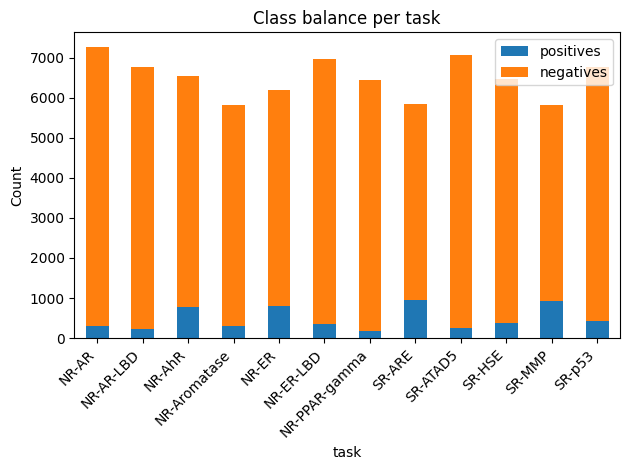

In [27]:
plt.figure(figsize=(10,5))
task_stats_df[["positives", "negatives"]].plot(kind="bar", stacked=True)
plt.ylabel("Count")
plt.title("Class balance per task")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save instead of just showing
plt.savefig("class_balance.png", dpi=300, bbox_inches="tight")

# Optionally also display
plt.show()

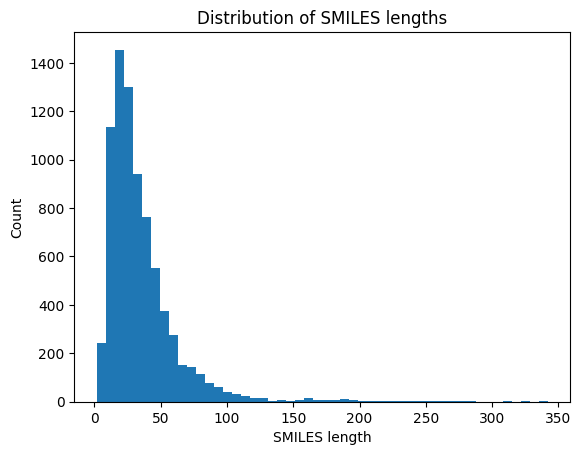

In [29]:
df["_smiles_len"] = df["smiles"].str.len()

plt.hist(df["_smiles_len"], bins=50)
plt.xlabel("SMILES length")
plt.ylabel("Count")
plt.title("Distribution of SMILES lengths")
plt.savefig("tox21_smiles_length.png", dpi=300, bbox_inches="tight")

plt.show()


In [23]:
# Binary mask (ignore NaNs)
bin_df = df[task_cols].fillna(0)

# Co-occurrence matrix: count of molecules where both tasks == 1
co_matrix = pd.DataFrame(
    np.dot(bin_df.T, bin_df),
    index=task_cols,
    columns=task_cols
)

# Normalize by diagonal (coexistence ratio)
co_ratio = co_matrix.div(np.diag(co_matrix), axis=0)

print("Co-occurrence counts:")
display(co_matrix)

Co-occurrence counts:


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
NR-AR,309.0,150.0,37.0,13.0,127.0,72.0,5.0,55.0,25.0,7.0,47.0,24.0
NR-AR-LBD,150.0,237.0,23.0,21.0,97.0,82.0,37.0,58.0,43.0,32.0,55.0,63.0
NR-AhR,37.0,23.0,768.0,79.0,197.0,70.0,29.0,247.0,119.0,78.0,267.0,111.0
NR-Aromatase,13.0,21.0,79.0,300.0,37.0,34.0,13.0,98.0,17.0,41.0,116.0,53.0
NR-ER,127.0,97.0,197.0,37.0,793.0,257.0,23.0,161.0,107.0,48.0,206.0,77.0
NR-ER-LBD,72.0,82.0,70.0,34.0,257.0,350.0,35.0,107.0,65.0,59.0,146.0,75.0
NR-PPAR-gamma,5.0,37.0,29.0,13.0,23.0,35.0,186.0,66.0,45.0,52.0,60.0,61.0
SR-ARE,55.0,58.0,247.0,98.0,161.0,107.0,66.0,942.0,106.0,144.0,305.0,154.0
SR-ATAD5,25.0,43.0,119.0,17.0,107.0,65.0,45.0,106.0,264.0,52.0,94.0,97.0
SR-HSE,7.0,32.0,78.0,41.0,48.0,59.0,52.0,144.0,52.0,372.0,131.0,108.0


In [24]:
print("Co-occurrence ratios (fraction of task A positives also positive in task B):")
display(co_ratio.round(3))

Co-occurrence ratios (fraction of task A positives also positive in task B):


,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53
NR-AR,1.000,0.485,0.120,0.042,0.411,0.233,0.016,0.178,0.081,0.023,0.152,0.078
NR-AR-LBD,0.633,1.000,0.097,0.089,0.409,0.346,0.156,0.245,0.181,0.135,0.232,0.266
NR-AhR,0.048,0.030,1.000,0.103,0.257,0.091,0.038,0.322,0.155,0.102,0.348,0.145
NR-Aromatase,0.043,0.070,0.263,1.000,0.123,0.113,0.043,0.327,0.057,0.137,0.387,0.177
NR-ER,0.160,0.122,0.248,0.047,1.000,0.324,0.029,0.203,0.135,0.061,0.260,0.097
NR-ER-LBD,0.206,0.234,0.200,0.097,0.734,1.000,0.100,0.306,0.186,0.169,0.417,0.214
NR-PPAR-gamma,0.027,0.199,0.156,0.070,0.124,0.188,1.000,0.355,0.242,0.280,0.323,0.328
SR-ARE,0.058,0.062,0.262,0.104,0.171,0.114,0.070,1.000,0.113,0.153,0.324,0.163
SR-ATAD5,0.095,0.163,0.451,0.064,0.405,0.246,0.170,0.402,1.000,0.197,0.356,0.367
SR-HSE,0.019,0.086,0.210,0.110,0.129,0.159,0.140,0.387,0.140,1.000,0.352,0.290


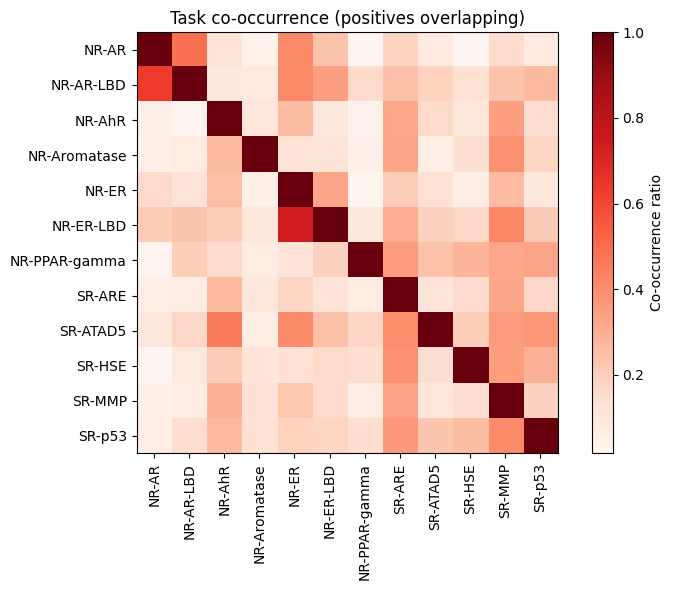

In [28]:
plt.figure(figsize=(8,6))
im = plt.imshow(co_ratio, cmap="Reds", interpolation="nearest")
plt.xticks(range(len(task_cols)), task_cols, rotation=90)
plt.yticks(range(len(task_cols)), task_cols)
plt.colorbar(im, label="Co-occurrence ratio")
plt.title("Task co-occurrence (positives overlapping)")
plt.tight_layout()
plt.savefig("tox21_cooccurrence.png", dpi=300, bbox_inches="tight")

plt.show()